# <center> Supervised Model : Linear Regression <center>

## <center> Profit prediction model for 50 Start-ups in USA <center>

In [1]:
# various libraries import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

from IPython.display import HTML

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## I. Requirements

**Task is to build the ML model that predicts the profit of startups in USA, find the model with the best possible results** 

## II. Data review and EDA

In [2]:
startup = pd.read_csv('50_Startups.csv')

In [3]:
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'

    return(HTML(s+css))

#View(startup)

In [4]:
display(startup.info())
display(startup.head())
display(startup.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


None

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


Each startup is described with the following features:

1. R&D Spend - Spent in Research and Development

2. Administration - Spent in Administration

3. Marketing Spend - Spent in Marketing

4. State - State / Location in USA

5. Profit - Profits (target feature)


Review the dependence of the target feature - profit on the numeric features. There are graphics of each numerical factors and scatterplot illustraing the dependence of the target feature on each of the factors. Additionally, on top of the scatterplot, there is a linear regression equation.

In [5]:
#Convert floats to integers - easy to work and review data

startup = startup.astype({"R&D Spend":'int', "Administration":'int', "Marketing Spend":'int', "Profit":'int'})

startup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   R&D Spend        50 non-null     int64 
 1   Administration   50 non-null     int64 
 2   Marketing Spend  50 non-null     int64 
 3   State            50 non-null     object
 4   Profit           50 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 2.1+ KB


In [6]:
types = startup.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']

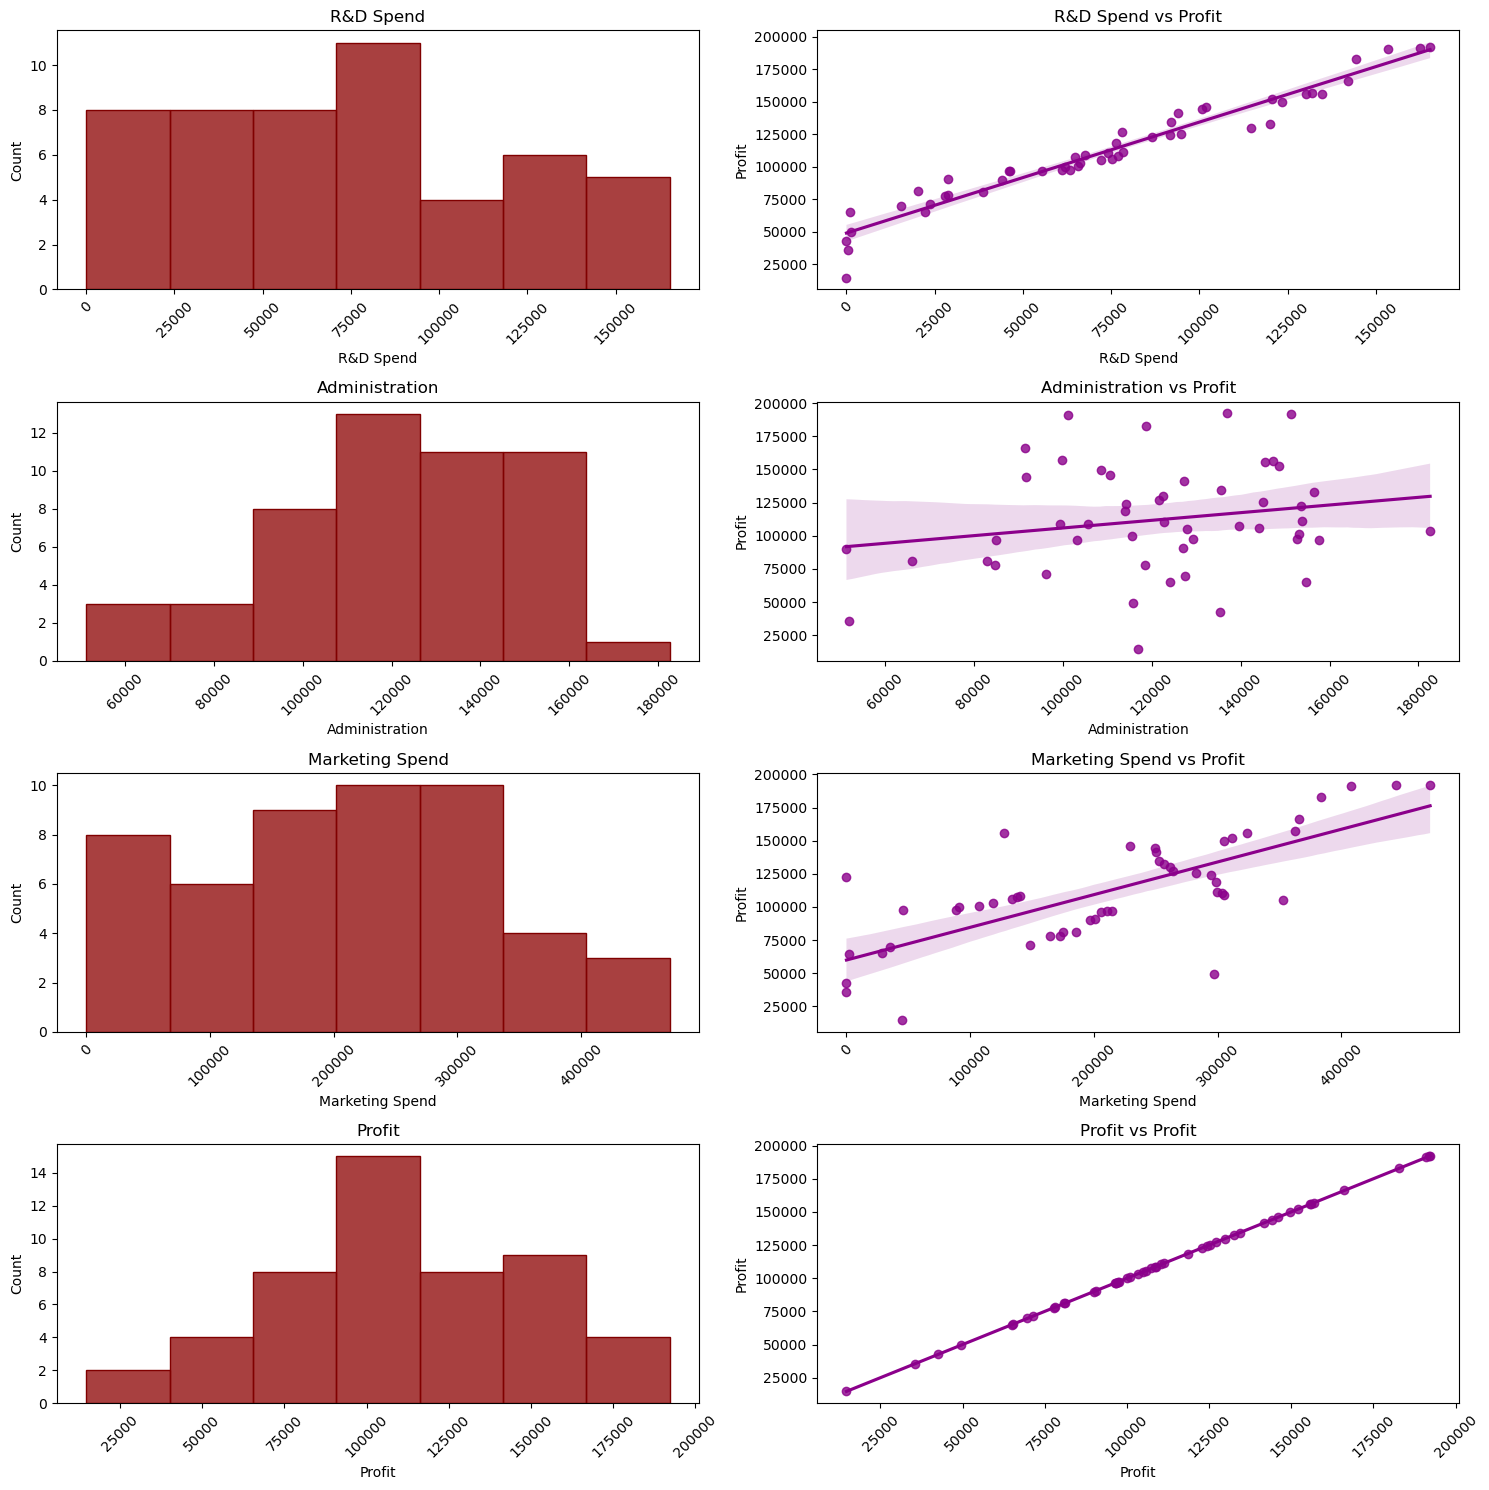

In [7]:
n = len(num_features)

fig, axes = plt.subplots(n, 2, figsize = (15, 15))

for i, feature in enumerate(num_features):
    
    histplot = sns.histplot(data = startup, x = feature, color = 'darkred', edgecolor = 'maroon', ax = axes[i][0])
    histplot.set_title('{}'.format(feature))
    histplot.xaxis.set_tick_params(rotation = 45)
    
    regplot = sns.regplot(data = startup, x = feature, y = 'Profit', color = 'darkmagenta', ax = axes[i][1])
    regplot.set_title('{} vs Profit'.format(feature))
    regplot.xaxis.set_tick_params(rotation = 45)

plt.tight_layout();

Reiew the correlation and research if there are any features that multicorrelated.

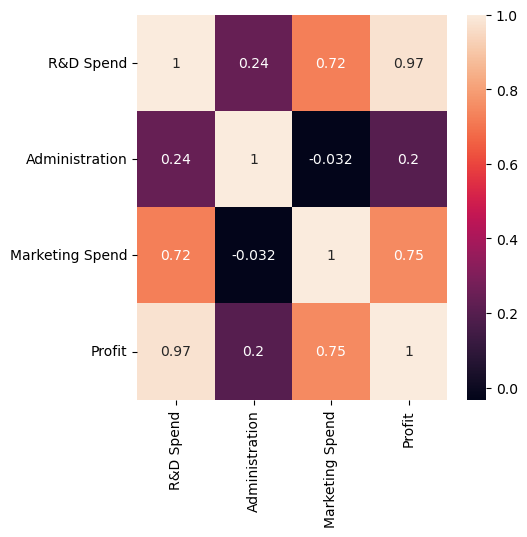

In [8]:
fig = plt.figure(figsize = (5, 5))
sns.heatmap(startup.corr(), annot = True);

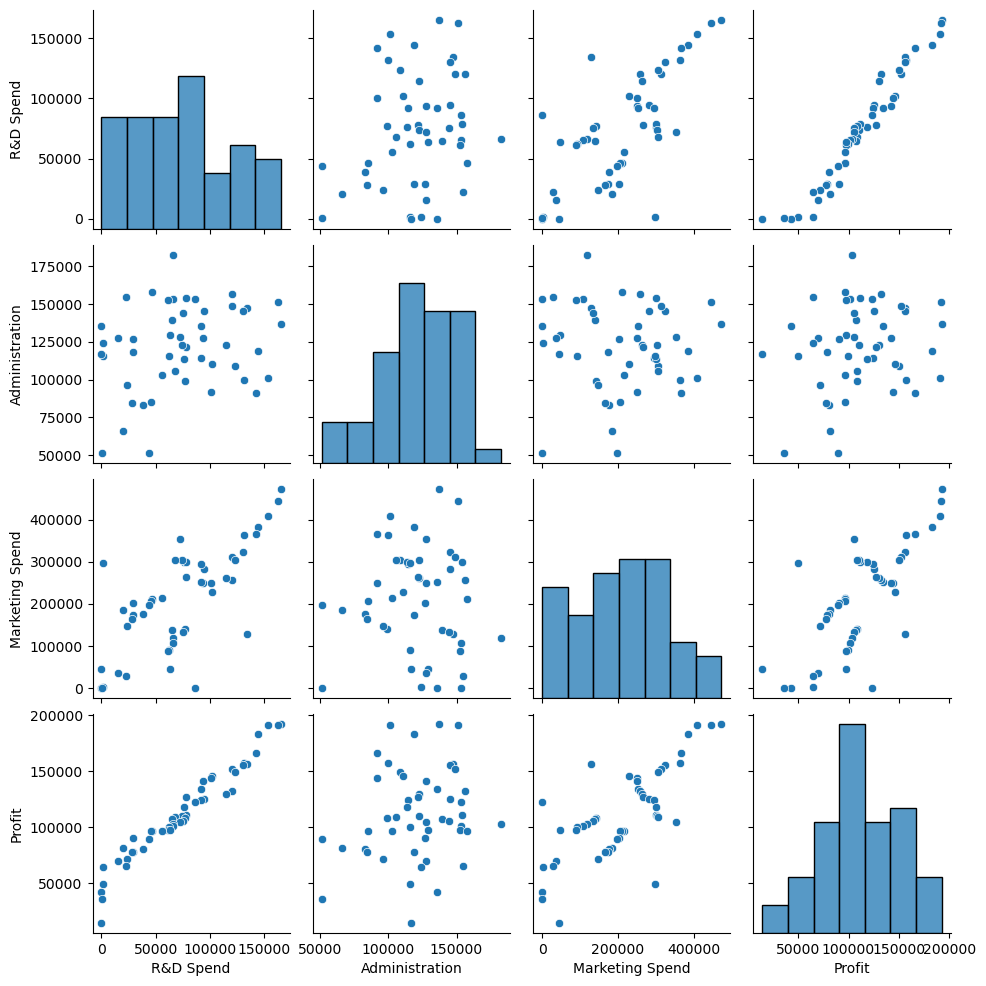

In [9]:
sns.pairplot(startup);

There is very strong correlaion between feature R&D Spend and the target feature - Profit.

### 1. Filling gaps (zero values)

In [10]:
startup[startup['R&D Spend'] == 0]

,R&D Spend,Administration,Marketing Spend,State,Profit
47,0,135426,0,California,42559
49,0,116983,45173,California,14681


In [11]:
startup[startup['Marketing Spend'] == 0]

,R&D Spend,Administration,Marketing Spend,State,Profit
19,86419,153514,0,New York,122776
47,0,135426,0,California,42559
48,542,51743,0,New York,35673


In [12]:
startup.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.120000,121344.160000,211024.640000,112012.100000
std,45902.243332,28017.769943,122290.245675,40306.158254
min,0.000000,51283.000000,0.000000,14681.000000
25%,39935.750000,103730.500000,129299.500000,90138.750000
50%,73050.500000,122699.000000,212715.500000,107978.000000
75%,101602.500000,144841.500000,299468.750000,139765.500000
max,165349.000000,182645.000000,471784.000000,192261.000000


In [13]:
# Replace value 0.0 in column "R&D Spend" & "Marketing Spend" with first quantile value. 
# It is possible that missing data was included in other columns with expenses.

startup.loc[(startup['R&D Spend'] == 0.0), 'R&D Spend'] = 39936
startup.loc[(startup['Marketing Spend'] == 0.0), 'Marketing Spend'] = 129300

### 2. New features

**It is interesting to review if amount of certain expenses would influence the size of the profit. Therefore the new features to be created.**

In [14]:
# 1. Total costs

startup['Total Expenses'] = startup['R&D Spend'] + startup['Administration'] + startup['Marketing Spend']

# 2. Relation between all known expenses and total expenses

startup['R&D_TE'] = startup['R&D Spend'] / startup['Total Expenses']
startup['Adm_TE'] = startup['Administration'] / startup['Total Expenses']
startup['Mrt_TE'] = startup['Marketing Spend'] / startup['Total Expenses']

In [15]:
View(startup)

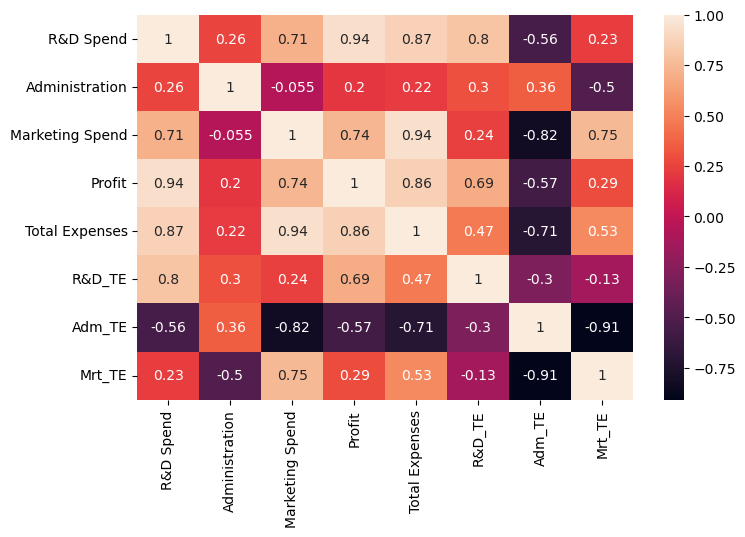

In [16]:
fig = plt.figure(figsize = (8, 5))
sns.heatmap(startup.corr(), annot = True);

In [17]:
startup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     int64  
 1   Administration   50 non-null     int64  
 2   Marketing Spend  50 non-null     int64  
 3   State            50 non-null     object 
 4   Profit           50 non-null     int64  
 5   Total Expenses   50 non-null     int64  
 6   R&D_TE           50 non-null     float64
 7   Adm_TE           50 non-null     float64
 8   Mrt_TE           50 non-null     float64
dtypes: float64(3), int64(5), object(1)
memory usage: 3.6+ KB


In [18]:
types = startup.dtypes
float_features = list(types[(types != 'object') & (types != 'int')].index)
float_features

['R&D_TE', 'Adm_TE', 'Mrt_TE']

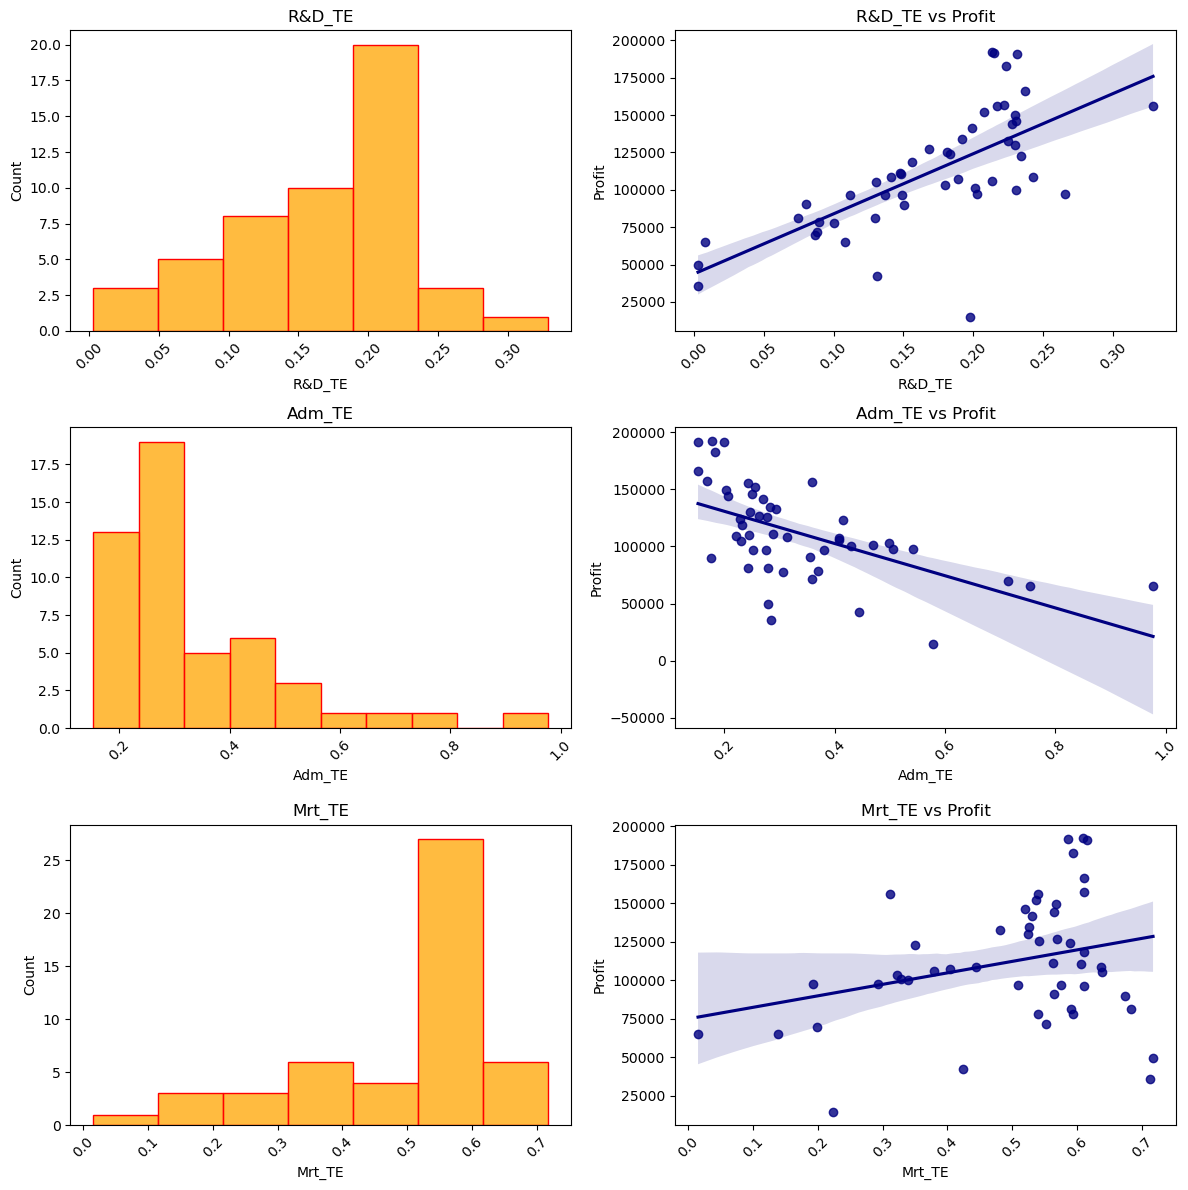

In [19]:
n = len(float_features)

fig, axes = plt.subplots(n, 2, figsize = (12, 12))

for i, feature in enumerate(float_features):
    
    histplot = sns.histplot(data = startup, x = feature, color = 'orange', edgecolor = 'red', ax = axes[i][0])
    histplot.set_title('{}'.format(feature))
    histplot.xaxis.set_tick_params(rotation = 45)
    
    regplot = sns.regplot(data = startup, x = feature, y = 'Profit', color = 'navy', ax = axes[i][1])
    regplot.set_title('{} vs Profit'.format(feature))
    regplot.xaxis.set_tick_params(rotation = 45)

plt.tight_layout();

### Conclusion: the major portion of costs is for the marketing, at the same time the size of expenses for research and development is only 20% of total costs. But the biggest influence on the profit is driven actually by R&D expenses.

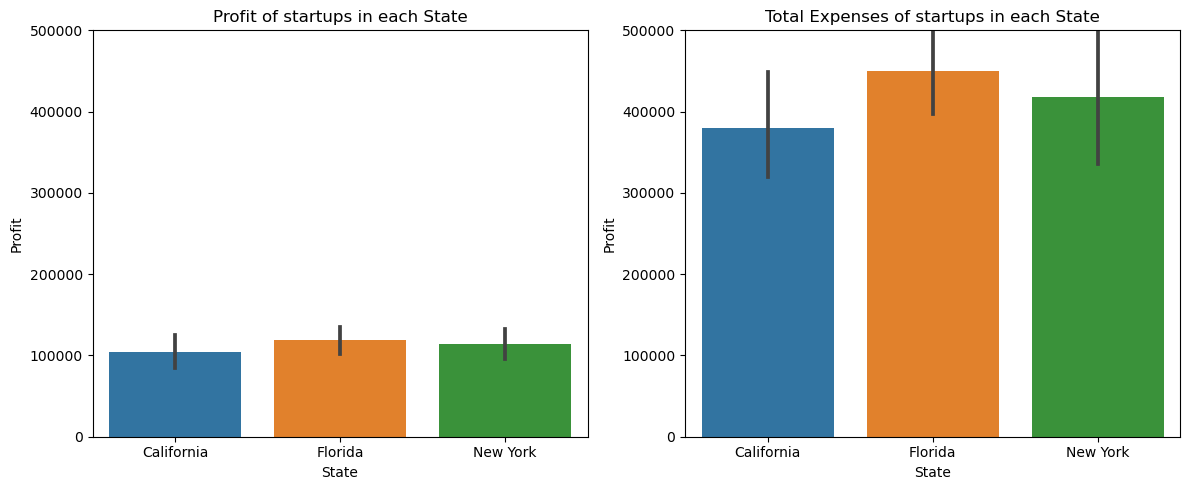

In [20]:
group_state = startup.groupby(['State'], as_index = False)[['Profit', 'Total Expenses']].value_counts()

#print(group_state)

figsize = (12, 5)
fig = plt.figure(figsize = figsize)
axes = fig.subplots(1,2)

ax = axes[0]

sns.barplot(data = group_state, x = 'State', y = 'Profit', ax = ax)
ax.set_title('Profit of startups in each State', fontsize = 12)
ax.set_ylabel('Profit', fontsize = 10)
ax.set_xlabel('State', fontsize = 10)
ax.set_ylim(0, 500000)
ax.set_yticks([0, 100000, 200000, 300000, 400000, 500000])

ax2 = axes[1]
sns.barplot(data = group_state, x = 'State', y = 'Total Expenses', ax = ax2)
ax2.set_title('Total Expenses of startups in each State', fontsize = 12)
ax2.set_ylabel('Profit', fontsize = 10)
ax2.set_xlabel('State', fontsize = 10)
ax2.set_ylim(0, 500000)
ax2.set_yticks([0, 100000, 200000, 300000, 400000, 500000])

plt.tight_layout();

### 3. Outliers

**It is also important to see if the dataset has outliers. If it does, the outliers shall be deleted. This would make the model to make better predictions.**

**Review of logarithmic distribution**

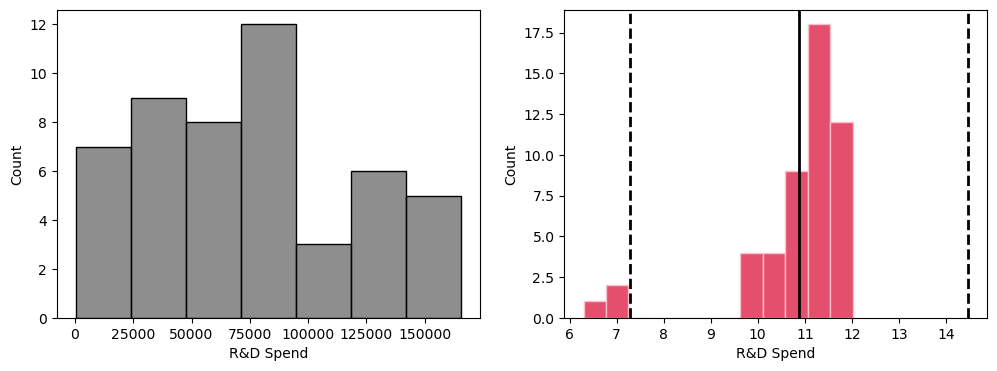

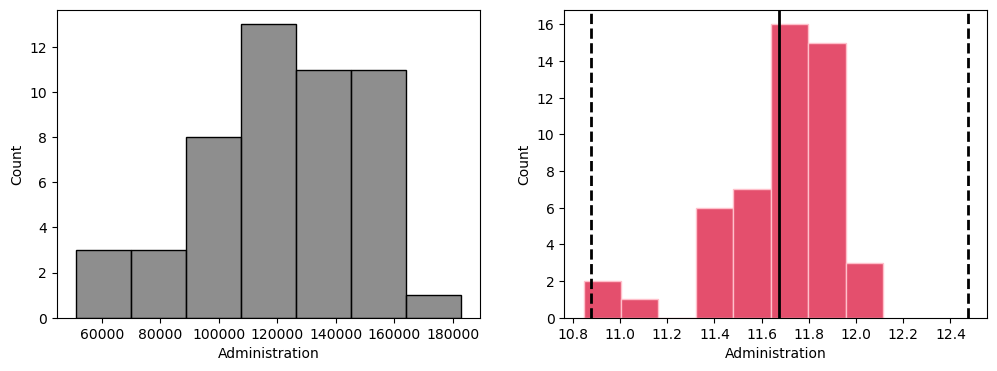

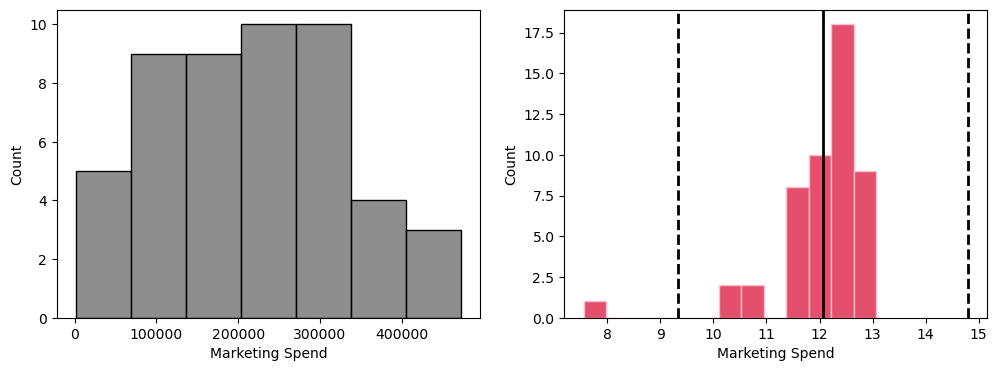

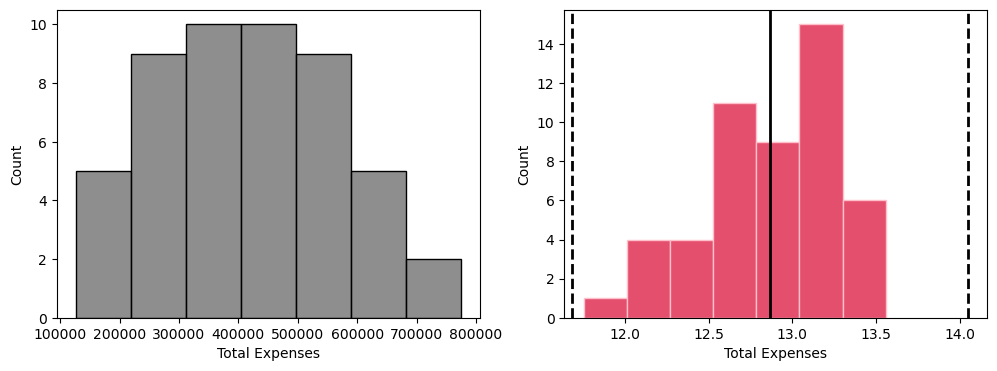

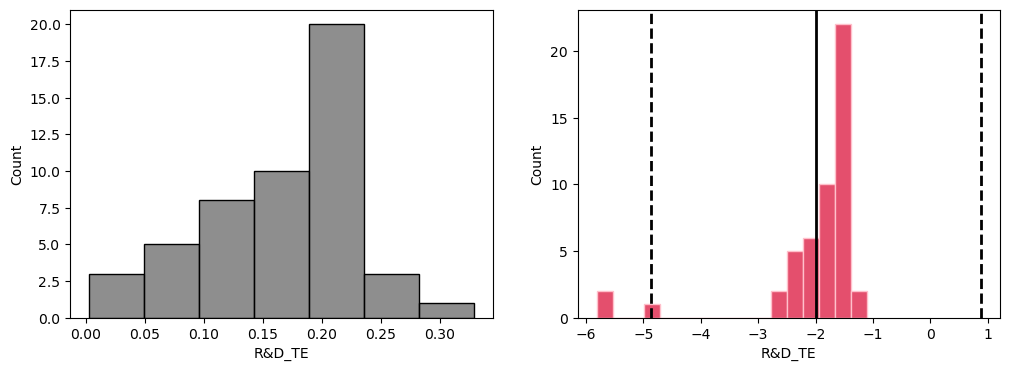

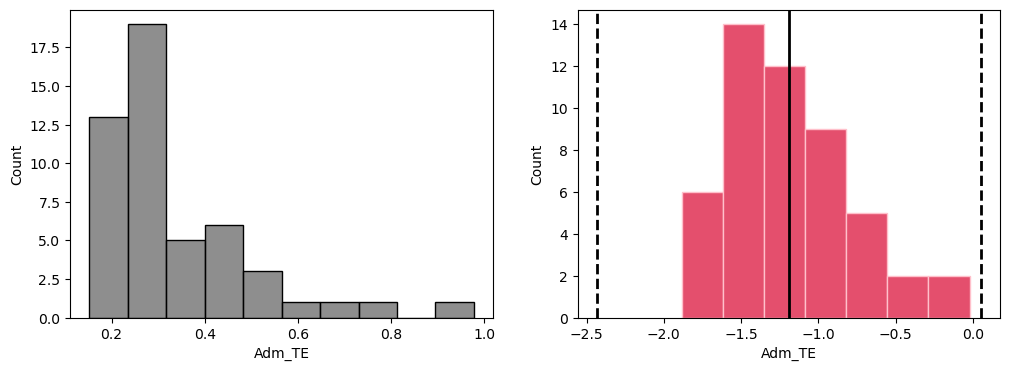

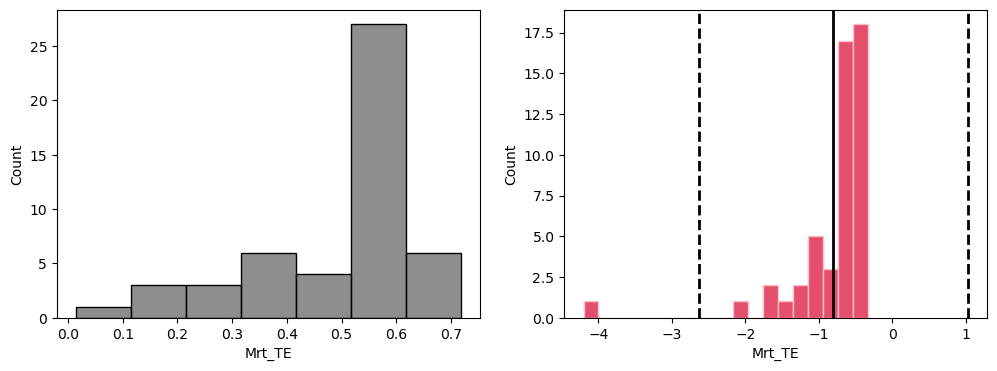

In [21]:
# FEATURE: Research and Development

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = startup, x = 'R&D Spend', color = 'dimgray', ax = axes[0]);

log_research = np.log(startup['R&D Spend'])

sns.histplot(data = log_research, color = 'crimson', edgecolor='pink', ax = axes[1]);

axes[1].axvline(log_research.mean(), color = 'k', lw = 2)
axes[1].axvline(log_research.mean()+ 3 *log_research.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_research.mean()- 3 *log_research.std(),
                color='k', ls='--', lw=2);


# FEATURE: Administration

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = startup, x = 'Administration', color = 'dimgray', ax = axes[0]);

log_administration = np.log(startup['Administration'])

sns.histplot(data = log_administration, color = 'crimson', edgecolor='pink', ax = axes[1]);

axes[1].axvline(log_administration.mean(), color = 'k', lw = 2)
axes[1].axvline(log_administration.mean()+ 3 *log_administration.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_administration.mean()- 3 *log_administration.std(),
                color='k', ls='--', lw=2);


# FEATURE: Maketing 

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = startup, x = 'Marketing Spend', color = 'dimgray', ax = axes[0]);

log_marketing = np.log(startup['Marketing Spend'])

sns.histplot(data = log_marketing, color = 'crimson', edgecolor='pink', ax = axes[1]);

axes[1].axvline(log_marketing.mean(), color = 'k', lw = 2)
axes[1].axvline(log_marketing.mean()+ 3 *log_marketing.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_marketing.mean()- 3 *log_marketing.std(),
                color='k', ls='--', lw=2);

# FEATURE: Total expenses 

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = startup, x = 'Total Expenses', color = 'dimgray', ax = axes[0]);

log_expenses = np.log(startup['Total Expenses'])

sns.histplot(data = log_expenses, color = 'crimson', edgecolor='pink', ax = axes[1]);

axes[1].axvline(log_expenses.mean(), color = 'k', lw = 2)
axes[1].axvline(log_expenses.mean()+ 3 *log_expenses.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_expenses.mean()- 3 *log_expenses.std(),
                color='k', ls='--', lw=2);

# FEATURE: Correlation between Research and Development spend vs Total expenses 

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = startup, x = 'R&D_TE', color = 'dimgray', ax = axes[0]);

log_rd_expenses = np.log(startup['R&D_TE'])

sns.histplot(data = log_rd_expenses, color = 'crimson', edgecolor='pink', ax = axes[1]);

axes[1].axvline(log_rd_expenses.mean(), color = 'k', lw = 2)
axes[1].axvline(log_rd_expenses.mean()+ 3 *log_rd_expenses.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_rd_expenses.mean()- 3 *log_rd_expenses.std(),
                color='k', ls='--', lw=2);

# FEATURE: Correlation between administration costs vs Total expenses 

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = startup, x = 'Adm_TE', color = 'dimgray', ax = axes[0]);

log_adm_expenses = np.log(startup['Adm_TE'])

sns.histplot(data = log_adm_expenses, color = 'crimson', edgecolor='pink', ax = axes[1]);

axes[1].axvline(log_adm_expenses.mean(), color = 'k', lw = 2)
axes[1].axvline(log_adm_expenses.mean()+ 3 *log_adm_expenses.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_adm_expenses.mean()- 3 *log_adm_expenses.std(),
                color='k', ls='--', lw=2);

# FEATURE: Correlation between marketing costs vs Total expenses 

fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = startup, x = 'Mrt_TE', color = 'dimgray', ax = axes[0]);

log_mrt_expenses = np.log(startup['Mrt_TE'])

sns.histplot(data = log_mrt_expenses, color = 'crimson', edgecolor='pink', ax = axes[1]);

axes[1].axvline(log_mrt_expenses.mean(), color = 'k', lw = 2)
axes[1].axvline(log_mrt_expenses.mean()+ 3 *log_mrt_expenses.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_mrt_expenses.mean()- 3 *log_mrt_expenses.std(),
                color='k', ls='--', lw=2);

### Conclusion: There are outliers in the dataset, but since the set contains only 50 rows and there are not many additional features that influence the target, it is not recommended to delete these outliers. Also it is obvious that data has to be stadartized and normalized before the modeling.

### 4. Encoding categorical column

In [22]:
startup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     int64  
 1   Administration   50 non-null     int64  
 2   Marketing Spend  50 non-null     int64  
 3   State            50 non-null     object 
 4   Profit           50 non-null     int64  
 5   Total Expenses   50 non-null     int64  
 6   R&D_TE           50 non-null     float64
 7   Adm_TE           50 non-null     float64
 8   Mrt_TE           50 non-null     float64
dtypes: float64(3), int64(5), object(1)
memory usage: 3.6+ KB


In [23]:
import category_encoders as ce

#Ordinal Encoding
# ord_enc = ce.OrdinalEncoder()
# startup['State'] = ord_enc.fit_transform(startup['State'])


startup_new = pd.get_dummies(startup)

## III. Modeling

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from itertools import compress


X = startup_new.drop(['Profit'], axis = 1)
y = startup_new['Profit']

print(X.shape)
print(y.shape)

(50, 10)
(50,)


#### Selecting the most correlated with the target features

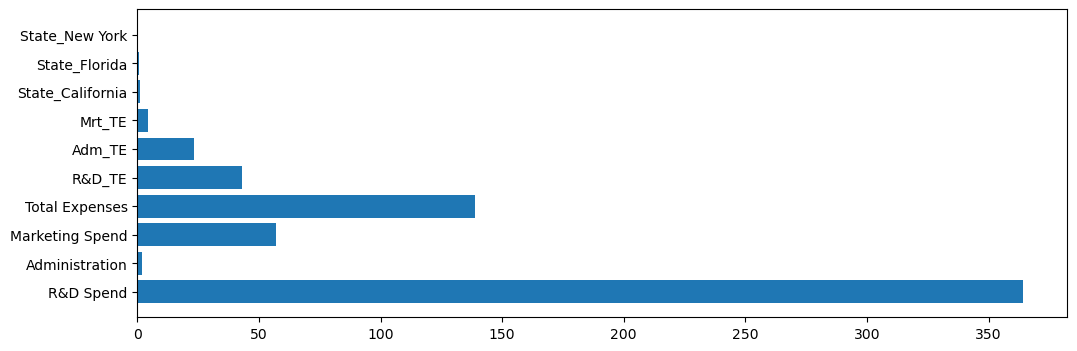

[]


In [25]:
skb = SelectKBest(f_regression, k = 10).fit(X, y) # according to graph below the least correlated feature is State, hence k value shall be 7
mask = skb.get_support()
name_col = X.columns.values

X_new = list(compress(name_col, mask))

result = list(set(X.columns) - set(X_new))
score_skb = skb.scores_

fig, ax = plt.subplots(figsize = (12, 4))
plt.barh(name_col, score_skb)
plt.show();

print(result)

According to the chart above, there are 4 none infomative features. But since the dataset is very small, it is not recommended to delete features.

In [26]:
startup_new.head()

,R&D Spend,Administration,Marketing Spend,Profit,Total Expenses,R&D_TE,Adm_TE,Mrt_TE,State_California,State_Florida,State_New York
0,165349,136897,471784,192261,774030,0.213621,0.176863,0.609516,0,0,1
1,162597,151377,443898,191792,757872,0.214544,0.199740,0.585716,1,0,0
2,153441,101145,407934,191050,662520,0.231602,0.152667,0.615731,0,1,0
3,144372,118671,383199,182901,646242,0.223402,0.183632,0.592965,0,0,1
4,142107,91391,366168,166187,599666,0.236977,0.152403,0.610620,0,1,0


In [27]:
X = startup_new.drop('Profit', axis = 1)
y = startup_new['Profit']

print(X.shape)
print(y.shape)

(50, 10)
(50,)


In [28]:
# divide dataset into train and test by ratio 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
print('\n')
print('Train shape: {}'.format(y_train.shape))
print('Test shape: {}'.format(y_test.shape))

Train shape: (35, 10)
Test shape: (15, 10)


Train shape: (35,)
Test shape: (15,)


In [29]:
# function to calculate and display metrics

def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE:  {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

#### First iteration of the modeling

In [30]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_train_predict = lr.predict(X_train)
y_test_predict = lr.predict(X_test)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.906
Train MAE: 9182.437
Train MAPE: 16.317


Test R^2: 0.705
Test MAE: 13695.825
Test MAPE:  20.396


#### Improving model performance by applying Polynomial Features & PowerTransformer

Train shape: (35, 65)
Test shape: (15, 65)


Train R^2: 1.000
Train MAE: 0.000
Train MAPE: 0.000


Test R^2: -5.326
Test MAE: 64813.170
Test MAPE:  81.250


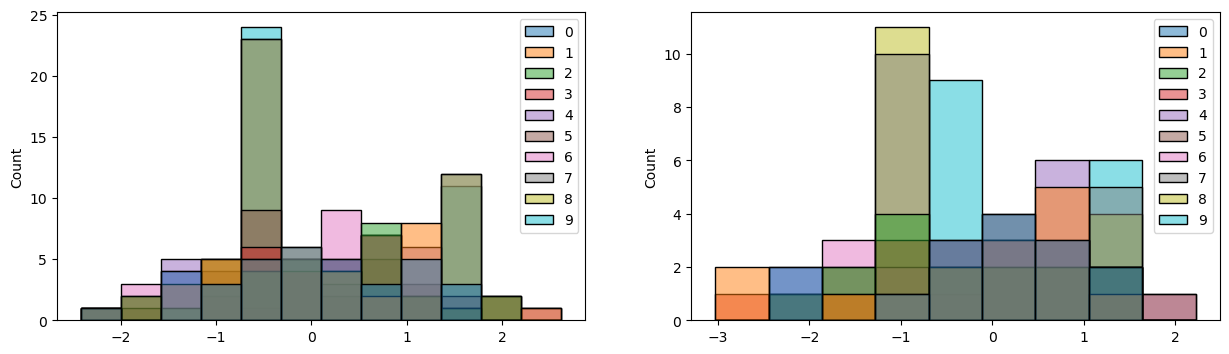

In [31]:
from sklearn.preprocessing import PowerTransformer

# Normlization
pt_scaler = PowerTransformer(method = 'yeo-johnson')
pt_scaler.fit(X_train)

X_train_pt_scaled = pt_scaler.transform(X_train)
X_test_pt_scaled = pt_scaler.transform(X_test)

# Creating Polynomial Features
poly = preprocessing.PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(X_train_pt_scaled)

X_train_pt_scaled_poly = poly.transform(X_train_pt_scaled)
X_test_pt_scaled_poly = poly.transform(X_test_pt_scaled)

print('Train shape: {}'.format(X_train_pt_scaled_poly.shape))
print('Test shape: {}'.format(X_test_pt_scaled_poly.shape))
print('\n')

# Visualization
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

sns.histplot(data = X_train_pt_scaled, ax = axes[0]);
sns.histplot(data = X_test_pt_scaled, ax = axes[1]);

# Linear Regression on normalized & polynomial features
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_pt_scaled_poly, y_train)

y_train_pred = lr_poly.predict(X_train_pt_scaled_poly) 
y_test_pred = lr_poly.predict(X_test_pt_scaled_poly)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

#### SGD Regressor & Normalization: MinMax

Train shape: (35, 10)
Test shape: (15, 10)


Train R^2: 0.515
Train MAE: 20464.814
Train MAPE: 29.729


Test R^2: 0.522
Test MAE: 20639.283
Test MAPE:  20.748


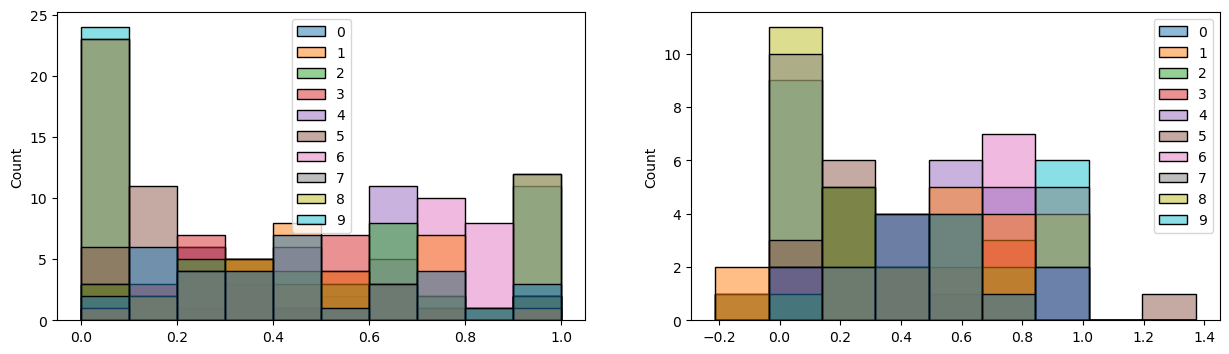

In [32]:
# Normlization
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train)

X_train_mm_scaled = mm_scaler.transform(X_train)
X_test_mm_scaled = mm_scaler.transform(X_test)

print('Train shape: {}'.format(X_train_mm_scaled.shape))
print('Test shape: {}'.format(X_test_mm_scaled.shape))
print('\n')

# Visualization
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

sns.histplot(data = X_train_mm_scaled, ax = axes[0]);
sns.histplot(data = X_test_mm_scaled, ax = axes[1]);

# SGD Regression on normalized features
sgd_lr = linear_model.SGDRegressor(alpha= 0.536, random_state = 42)
sgd_lr.fit(X_train_mm_scaled, y_train) 

y_train_pred = sgd_lr.predict(X_train_mm_scaled) 
y_test_pred = sgd_lr.predict(X_test_mm_scaled)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

#### L-2 Ridge regularization

In [33]:

ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_pt_scaled_poly, y_train)

y_train_predict = ridge_lr_poly.predict(X_train_pt_scaled_poly)
y_test_predict = ridge_lr_poly.predict(X_test_pt_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.985
Train MAE: 3687.568
Train MAPE: 4.391


Test R^2: 0.493
Test MAE: 22131.337
Test MAPE:  27.689


**Selection of $\alpha$ parameter**

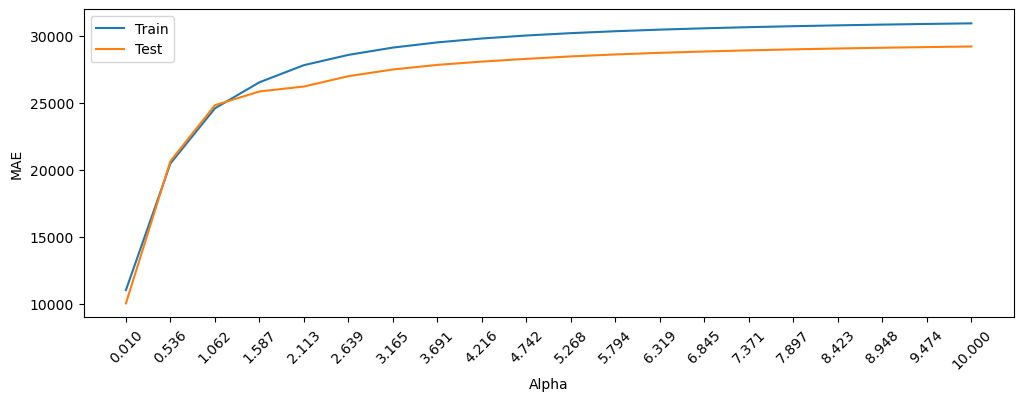

In [34]:
alpha_list = np.linspace(0.01, 10, 20)

train_scores = []
test_scores = []

for alpha in alpha_list:
    sgd_lr = linear_model.SGDRegressor(alpha=alpha, random_state = 42)
    sgd_lr.fit(X_train_mm_scaled, y_train) 
    
    y_train_pred = sgd_lr.predict(X_train_mm_scaled)
    y_test_pred = sgd_lr.predict(X_test_mm_scaled)
    
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_pred))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_pred))
    
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(alpha_list, train_scores, label = 'Train')
ax.plot(alpha_list, test_scores, label = 'Test')

ax.set_xlabel('Alpha')
ax.set_ylabel('MAE')
ax.set_xticks(alpha_list)
ax.xaxis.set_tick_params(rotation = 45)
ax.legend();

In [35]:
sgd_lr = linear_model.SGDRegressor(alpha= 0.530, random_state = 42)
sgd_lr.fit(X_train_mm_scaled, y_train) 

y_train_pred = sgd_lr.predict(X_train_mm_scaled) 
y_test_pred = sgd_lr.predict(X_test_mm_scaled)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.517
Train MAE: 20412.250
Train MAPE: 29.694


Test R^2: 0.525
Test MAE: 20579.904
Test MAPE:  20.708
